In [1]:
import augur

# import everything from githubapi.py and ghtorrent.py so we can
# just copy and paste our function later
import json
import re
from dateutil.parser import parse
import pandas as pd
import github
import numpy as np
import sqlalchemy as s
import datetime
import requests

%matplotlib inline

# create an Augur application so we can test our function
augurApp = augur.Application('../augur.cfg')
ghtorrent = augurApp.ghtorrent()

2018-07-04 00:53:01 mwc-037228.dhcp.missouri.edu augur[5485] ERROR /Users/carterlandis/Documents/Code/augur/augur.cfg could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: Expecting value: line 1 column 1 (char 0)
2018-07-04 00:53:01 mwc-037228.dhcp.missouri.edu augur[5485] ERROR Could not connect to GHTorrent database. Error: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on '127.0.0.1' ([Errno 61] Connection refused)") (Background on this error at: http://sqlalche.me/e/e3q8)


In [3]:
def community_engagement(self, owner, repo):
    """
    Lots of information about issues and pull requests

    TODO: More documentation

    :param owner: The name of the project owner
    :param repo: The name of the repo
    :return: DataFrame with each row being a week
    """
    repoid = self.repoid(owner, repo)
    issuesFullSQL = s.sql.text("""
    SELECT DATE(date) as "date", 
           SUM(issues_opened) AS "issues_opened",
           SUM(issues_closed) AS "issues_closed",
           SUM(pull_requests_opened) AS "pull_requests_opened",
           SUM(pull_requests_merged) AS "pull_requests_merged",
           SUM(pull_requests_closed) AS "pull_requests_closed"

    FROM (

        SELECT issue_events.created_at as "date", 
               issue_events.action = "closed" AND issues.pull_request = 0  AS issues_closed,
               0 AS pull_requests_closed,
               0 AS pull_requests_merged,
               issue_events.action = "reopened" AND issues.pull_request = 0 AS issues_opened,
               0 AS pull_requests_opened
        FROM issues
        LEFT JOIN issue_events
        ON issue_events.issue_id = issues.id
        LEFT JOIN pull_request_history
        ON pull_request_history.pull_request_id = issues.pull_request_id
        WHERE issues.repo_id = :repoid

        UNION ALL

        SELECT pull_request_history.created_at as "date", 
               0 AS issues_closed,
               pull_request_history.action = "closed" AND issues.pull_request = 1  AS pull_requests_closed,
               pull_request_history.action = "merged" AND issues.pull_request = 1   AS pull_requests_merged,
               0 AS issues_opened,
               pull_request_history.action = "reopened" AND issues.pull_request = 1 AS pull_requests_opened
        FROM issues
        LEFT JOIN pull_request_history
        ON pull_request_history.pull_request_id = issues.pull_request_id
        WHERE issues.repo_id = :repoid

        UNION ALL

        SELECT issues.created_at as "date",
               0 AS issues_closed,
               0 AS pull_requests_closed,
               0 AS pull_requests_merged,
               issues.pull_request = 0 AS issues_opened,
               issues.pull_request AS pull_requests_opened

        FROM issues
        WHERE issues.repo_id = :repoid

    ) summary

    GROUP BY YEARWEEK(date)
    """)
    counts = pd.read_sql(issuesFullSQL, self.db, params={"repoid": str(repoid)})
    # counts.drop(0, inplace=True)
    counts['issues_opened_total'] = counts.issues_opened.cumsum()
    counts['issues_closed_total'] = counts.issues_closed.cumsum()
    counts['issues_closed_rate_this_window'] = counts.issues_closed / counts.issues_opened
    counts['issues_closed_rate_total'] = counts.issues_closed_total / counts.issues_opened_total
    counts['issues_delta'] = counts.issues_opened - counts.issues_closed
    counts['issues_open'] = counts['issues_delta'].cumsum()
    counts['pull_requests_opened_total'] = counts.pull_requests_opened.cumsum()
    counts['pull_requests_closed_total'] = counts.pull_requests_closed.cumsum()
    counts['pull_requests_closed_rate_this_window'] = counts.pull_requests_closed / counts.pull_requests_opened
    counts['pull_requests_closed_rate_total'] = counts.pull_requests_closed_total / counts.pull_requests_opened_total
    counts['pull_requests_delta'] = counts.pull_requests_opened - counts.pull_requests_closed
    counts['pull_requests_open'] = counts['pull_requests_delta'].cumsum()
    return counts

augur.GHTorrent.community_engagement = community_engagement

AttributeError: module 'augur' has no attribute 'GHTorrent'

In [6]:
# Get the dataframe
com_eng_df = ghtorrent.community_engagement('rails', 'rails')
com_eng_df = com_eng_df.set_index(['date'])

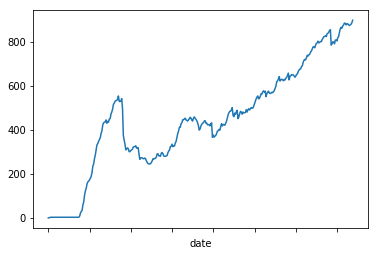

In [7]:
# Issues open
com_eng_df['issues_open'].plot()

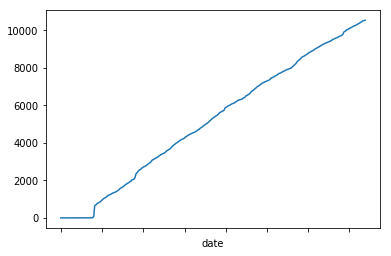

In [8]:
# Issues open
com_eng_df['issues_closed_total'].plot()